In [15]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss, MSELoss

# Run specific
DATASET = "cadena" # "mnist", "fashion-mnist", "cifar"
EPOCHS = 10
QUBITS = 2
NEURONS_FROM=4
NEURONS_PREDICTED=1
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
LOSS_FUNC = MSELoss(reduction="sum")
PERTURB = False
RESUME_TRAINING = True
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
TRAINING_RUN = "v89"
# Constants
QC_REPETITIONS = 1
BATCH_SIZE = 256


FILENAME_PREFIX = f'v3-{DATASET}-r{TRAINING_RUN}-q{QUBITS}-{QC_REPETITIONS}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
elif DATASET == "cadena":
   IMAGE_WIDTH = 40
   TARGETS = []
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])


## Settings
DEBUG = False
SAMPLE_RUN = False
SAMPLE_ITERATIONS = 10


In [16]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators.base_operator import BaseOperator

from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
    AvgPool2d,
    ELU
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAtV2
from canonicallayers.gaborfilterextractor import extract_power_featsV2
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform

import csv
import logging
import os
import time

import matplotlib
from cadena_ploscb.data import Dataset, MonkeySubDataset

algorithm_globals.random_seed = 42

device = torch.device("cpu")

print(device)

# torch.cuda.set_per_process_memory_fraction(0.5, 0)
torch.cuda.empty_cache()

cpu


In [17]:
# Step 3: Prepare Training data
# -------------

data_dict = Dataset.get_clean_data()
dataset = MonkeySubDataset(data_dict, seed=1000, train_frac=0.8, subsample=2, crop=30)

# b_out is calculated as inverse ELU of responses mean
# Used as input for non-linear mapping the model output to neuron firing rates
_, responses, _ = dataset.train()
print(responses.shape)

Subtracting mean: 112.51203
(18560, 166)


In [18]:
  images_test, responses_test, real_responses_test = dataset.test()
  sresps_test = responses_test[:,NEURONS_FROM:NEURONS_FROM+NEURONS_PREDICTED]
  print("predicted neurons", sresps_test.shape, "sum", sresps_test.sum(axis=2).squeeze(), "mean", sresps_test.mean(axis=2).squeeze())
  print("min", sresps_test.min(axis=2).squeeze(),"max", sresps_test.max(axis=2).squeeze(), "std", sresps_test.std(axis=2).squeeze())
  MAX = sresps_test.max()
  print("MAX", MAX)

predicted neurons (4, 1, 166) sum [366. 360. 359. 344.] mean [2.2048192 2.1686747 2.1626506 2.0722892]
min [0. 0. 0. 0.] max [14. 16. 19. 15.] std [2.6808515 2.7146158 2.8077006 2.575525 ]
MAX 19.0


In [19]:
# PLOT = True
# BATCH_SIZE = 256
# if(PLOT):
#   rows = 2
#   fig, axes = plt.subplots(nrows=rows, ncols=rows, sharex=True, figsize=(20, 20))
#   img_batch, res_batch, real_batch = dataset.minibatch(BATCH_SIZE)
#   print("img_batch", img_batch.shape)
#   images = torch.tensor(img_batch).permute(0, 3, 1, 2)
#   print("images", images.shape)
#   print("squeezed", images[0].squeeze().shape)
#   for p in range(rows * rows):
#     axes[p//rows,p%rows].imshow(images[p].squeeze(), cmap="gray")
#     axes[p//rows,p%rows].set_xticks([])
#     axes[p//rows,p%rows].set_yticks([])

#   fig, axes = plt.subplots(nrows=rows, ncols=rows, sharex=True, figsize=(30, 30))
#   for p in range(rows * rows):
#     axes[p//rows,p%rows].imshow(img_batch[p].squeeze(), cmap="gray")
#     axes[p//rows,p%rows].set_xticks([])
#     axes[p//rows,p%rows].set_yticks([])

In [20]:
# Step 7- Define QNN Model

# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(QUBITS, reps=QC_REPETITIONS)
    ansatz = RealAmplitudes(QUBITS, reps=1)
    qc = QuantumCircuit(QUBITS)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        # observables=SparsePauliOp(['IIII', 'IIII', 'IIII', 'IIII'])
    )
    return qnn


qnn1 = create_qnn()


In [21]:
# Define Hybrid torch NN Module

class Net(Module):
    def __init__(self, qnn1):
      super().__init__()
      self.conv1 = Conv2d(1, 32, kernel_size=13,padding='valid').to(device)
      self.pool = AvgPool2d(kernel_size=5, stride=1, padding=2).to(device)
      self.fc1 = Linear(32*28*28, QUBITS).to(device)  # 32 * QUBIT-dimensional output
      # self.fc2 = Linear(32*QUBITS, QUBITS).to(device)  # QUBIT-dimensional output
      self.elu = ELU()
      self.qnn1 = TorchConnector(qnn1).to(device)  # Apply torch connector, weights chosen
      self.relu = ReLU().to(device)

    def forward(self, x):
      x = x.permute(0, 3, 1, 2)
      if(DEBUG):
        print("x shape", x.shape)
      x = self.elu(self.conv1(x))
      # print("conv1", x[0, 0, 0, 0])
      x = self.elu(self.pool(x))
      # print("pool", x[0, 0, 0, 0])
      x = self.elu(self.fc1(torch.flatten(x, start_dim=1).to(device)))
      # print("fc1", x[0, 0])
      # x = self.relu(self.fc2(x))
      # print("fc2", x[0, 0])
      x = torch.abs(self.qnn1(x)).to(device) * MAX
      # print("qnn", x[0, 0])
      if(DEBUG):
        print("After qnn, output", x.shape, x[0:3, :])
      return x




In [22]:
# Step 11 - Initialize model

model = Net(qnn1)

In [23]:
# Step 12 - Load previous results

model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))
loss_list = torch.load(f"checkpoints/{FILENAME_PREFIX}-losslist.pt")
 

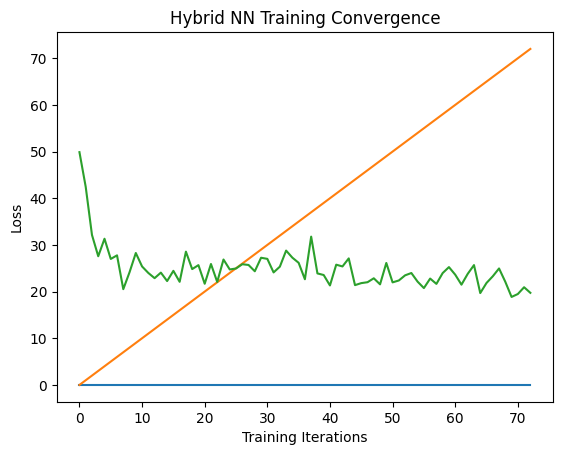

In [24]:
# Step 13 - Plot Prior Losses
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

In [ ]:
#Calculate Fraction of Explainable Variance
def calculateFEV3(predictions_test, responses_test, real_responses_test, 
  nrep, nim, tneu, nneu, fneu):
  predictions_test = torch.tile(predictions_test, (4, 1)).detach().cpu().numpy()
  resps_test_nan = dataset.nanarray(real_responses_test, responses_test)
  resps_test = resps_test_nan.reshape([nrep * nim, tneu])
  sresps_test = resps_test[:,fneu:fneu+nneu]
  MSE = np.nanmean((predictions_test - sresps_test) ** 2, axis=0)
  obs_var_avg, total_variance, explainable_var = [], [], []
  for n in range(tneu):
    if(n < NEURONS_FROM or n >= NEURONS_FROM + NEURONS_PREDICTED):
      continue
    rep = dataset.repetitions[n]
    resp_ = resps_test_nan[:rep, :, n]
    v = np.nanvar(resp_, axis=0, ddof=1)
    obs_var = np.nanmean(v, axis=0)
    obs_var_avg.append(obs_var)
    tot_var = np.nanvar(resp_, axis=(0, 1), ddof=1)
    total_variance.append(tot_var)
    explainable_var.append(tot_var - obs_var)
  total_variance = np.array(total_variance)
  explainable_var = np.array(explainable_var)
  var_explained = total_variance - MSE
  fevPercent = (var_explained / explainable_var).mean() * 100
  return fevPercent

In [25]:
#Calculate Fraction of Explainable Variance
def calculateFEV3(predictions_test, responses_test, real_responses_test, 
  nrep, nim, tneu, nneu, fneu):
  predictions_test = torch.tile(predictions_test, (4, 1)).detach().cpu().numpy()
  resps_test_nan = dataset.nanarray(real_responses_test, responses_test)
  resps_test = resps_test_nan.reshape([nrep * nim, tneu])
  sresps_test = resps_test[:,fneu:fneu+nneu]
  print("sresps_test", sresps_test.shape, "SUM", sresps_test.sum(), "mean", sresps_test.mean())
  print("min", sresps_test.min(),"max", sresps_test.max(), "std", sresps_test.std())
  print("predictions_test", predictions_test.shape, "sum", predictions_test.sum(), "mean", predictions_test.mean())
  print("min", predictions_test.min(),"max", predictions_test.max(), "std", predictions_test.std())
  MSE = np.nanmean((predictions_test - sresps_test) ** 2, axis=0)
  obs_var_avg, total_variance, explainable_var = [], [], []
  for n in range(tneu):
    if(n < NEURONS_FROM or n >= NEURONS_FROM + NEURONS_PREDICTED):
      continue
    # print("processing for neuron", n)
    rep = dataset.repetitions[n]
    resp_ = resps_test_nan[:rep, :, n]
    # print("resp_", resp_.shape, resp_[:, 0:4])
    v = np.nanvar(resp_, axis=0, ddof=1)
    # print("v", v.shape, v[0:4])
    obs_var = np.nanmean(v, axis=0)
    # print("obs_var", obs_var)
    obs_var_avg.append(obs_var)
    tot_var = np.nanvar(resp_, axis=(0, 1), ddof=1)
    # print("tot_var", tot_var)
    total_variance.append(tot_var)
    explainable_var.append(tot_var - obs_var)
  total_variance = np.array(total_variance)
  explainable_var = np.array(explainable_var)
  var_explained = total_variance - MSE
  print("MSE", MSE)
  print("total_variance", total_variance)
  print("var_explained", var_explained)
  print("explainable_var", explainable_var)
  print("explainable_var total", NEURONS_FROM, explainable_var.sum())
  return var_explained / explainable_var

In [26]:
# Step 14 - Extact features

# Define model, optimizer, and loss function
start_time = datetime.now()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = LOSS_FUNC

# Start training
epochs = EPOCHS  # Set number of epochs
model.eval()  # Set model to training mode
# m = Softmax(dim=3)

images_test, responses_test, real_responses_test = dataset.test()
total_count = images_test.shape[0]
iterations = total_count//BATCH_SIZE +1

nrep, nim, tneu = responses_test.shape
nneu = NEURONS_PREDICTED
fneu = NEURONS_FROM

print("total_count", total_count, "iterations", iterations)
print("loss_list", loss_list[-1:], len(loss_list))
print(DATASET, QUBITS, "Qubits, ", "Batch Size:", BATCH_SIZE)
with no_grad():

    correct = 0
    total = 0

    predictions = torch.zeros(1, NEURONS_PREDICTED)

    for batch_idx in range(iterations):
      data = torch.Tensor(images_test[batch_idx*BATCH_SIZE:(batch_idx+1)*BATCH_SIZE]).to(device)
      target = torch.Tensor(responses_test[0, batch_idx*BATCH_SIZE:(batch_idx+1)*BATCH_SIZE]).to(device)
      # print("data", data.shape, "target",target.shape)
      output = model(data)
      if batch_idx == 0:
        predictions = output
        print(batch_idx, "output", output[0, :], "target", target[0, NEURONS_FROM:NEURONS_FROM+NEURONS_PREDICTED], "MSE", torch.mean((target - output) ** 2).item() )
      else:
        predictions = torch.cat((predictions, output))
        print(batch_idx, "output", output[0, :], "target", target[0, NEURONS_FROM:NEURONS_FROM+NEURONS_PREDICTED], "MSE", torch.mean((target - output) ** 2).item() )
  

total_count 1450 iterations 6
loss_list [[0, 72, 19.733917236328125]] 73
cadena 2 Qubits,  Batch Size: 256
0 output tensor([13.2797]) target tensor([7.]) MSE 32.616600036621094
1 output tensor([9.7874]) target tensor([4.]) MSE 33.25829315185547
2 output tensor([2.0712]) target tensor([1.]) MSE 30.351238250732422
3 output tensor([2.5267]) target tensor([5.]) MSE 39.54644012451172
4 output tensor([2.1914]) target tensor([6.]) MSE 26.57120704650879
5 output tensor([6.1474]) target tensor([0.]) MSE 30.708223342895508


In [27]:
  NEURONS_FROM = 0
  fev = calculateFEV3(predictions, responses_test, real_responses_test, nrep, nim, tneu, nneu, fneu)
  print("FEV", fev * 100)
  print("FEV%", f'{{:.0f}}%'.format(fev.mean() * 100, "%"))
  print("loss_list", loss_list[-1:], len(loss_list))


sresps_test (5800, 1) SUM 23174.0 mean 3.9955173
min 0.0 max 13.0 std 2.6066852
predictions_test (5800, 1) sum 29284.69 mean 5.049084
min 0.0069918833 max 15.902944 std 3.8401668
MSE [22.727802]
total_variance [1.1884079]
var_explained [-21.539394]
explainable_var [0.3649596]
explainable_var total 0 0.3649596
FEV [-5901.8574]
FEV% -5902%
loss_list [[0, 72, 19.733917236328125]] 73


In [28]:
import qiskit.tools.jupyter

%qiskit_version_table